In [293]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
import bisect
from scipy.signal import find_peaks

In [294]:
IMGPATH = Path('data') #użycie Path zamiast stringów ze scieszką pozwala unikać problemów z uruchamianiem na różnych systemach
TRAINPATH = Path('train')
TRAINPATH.mkdir(exist_ok = True)

In [295]:
def captchas(): # generowanie listy pathów do plików 
    return list(IMGPATH.glob('*.png'))

In [296]:
def random_captcha(): # wylosowanie 1 randomowej ścieżki 
    return random.choice(captchas())

In [ ]:
## w colect_edges  skalujemy wszystkie obrazki do średniej wielkości liter

In [ ]:
# convert('L') luminance -> zamiana na czarno-białe

# zip(edges, edges[1:]) bo musimy iterować po parze left, right z eges

# box parametr określający wspołrzędne bloku do wycięcia
# size to docelowy rozmiar fragmentu
# rezemple -> rodzaj interpolacji tu lanczos

#np.arr(piece) /255 poto by wartości były w przedziale od0 do 1



#@property 
#...
#zmieni wymiar zestakowanych tablic z pieces (literami) na 3 wymiarowy zbiór danych (ilość pieces, wysokość, szerokość litery)

In [297]:
class tools:
    @staticmethod
    def divie_weighted (left, right, weights): #dzielenie znaków proporcjonalnie do długościw oparciu o wagi
        sums = np.array(weights).cumsum()     # działa tak jak aggregate w itertools
        #cumsum() kumuluje sumy z poprzednichelementów
        fractions = np.insert(sums,0,0)/sums[-1]
        return left + fractions * (right-left)
    @staticmethod
    def char_weights (string):
        weights = {'m': 3, 'w': 3, 'l': 1,'i':1}
        return [weights.get(char,2) for char in string]

    @staticmethod
    def to_left(array, x):
        i = bisect.bisect_right(array, x)
        return array[i-1] if i else None
    
    @staticmethod
    def to_right(array, x):
        'Find leftmost item greater than or equal to x'
        i = bisect.bisect_left(a, x)
        return a[i] if i != len(a) else None
    
    @staticmethod
    def clamp(value, origin, limit = 0):
        return (origin if limit and abs(value-origin) > limit else value)
    @staticmethod
    def clamped_dist (value,origin, limit = 0):
        d = abs(value - origin)
        return d if limit and d <= limit else np.inf
    
    @staticmethod
    def closest(values, origin, limit = 0):
        candidates = [tools.to_left(values, origin),
                tools.to_left(values, origin)]
        candidate = min(filter(lambda c: c is not None, candidates), key = lambda c: tools.clamped_dist(c, origin, limit))
        return tools.clamp(candidate, origin, limit)
    

#  Coś w tym rejonie nie bangla

ValueError: min() arg is an empty sequence

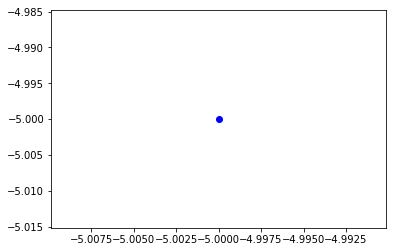

In [298]:
arr = [1,5,12,21,30]
limit = 3
scope = range(-5,40)
for origin in scope:
    plt.scatter(origin, origin, c='b')
    closest = tools.closest(arr,origin, limit)
    plt.scatter(closest,origin, c ='r')
for x in arr:
    plt.axvline()

In [ ]:
w = [1, 2,1]
tools.divie_weighted(10,50,w)

In [299]:
tools.char_weights('mnfhfkw')

[3, 2, 2, 2, 2, 2, 3]

In [300]:
# jakiś przykład
w = [1, 2,1]
np.insert(np.array(w).cumsum(),0,0)

array([0, 1, 3, 4], dtype=int32)

In [301]:
class Slicer:
    def __init__(self, paths):
        self.paths = list(paths)
        
    # wszystkie nazwy które występują w przestrzeni nazwy klasy mogą mieć dowolne nazwy
    
    # do wywołanie tej metody nie jest potrzebny parametr self 
    @staticmethod      # nie ma nic wspolnego z prywatonścią                 
    def _find_edges( imagepath):
        
        image = PIL.Image.open(imagepath)
        pixels = np.array(img.convert('1', dither = PIL.Image.NONE)) # nie potrzeba obrazka yulko siatkę pixeli czyli tablicę numpy
        columns = (~pixels).sum(axis =0)
        
        _, dark_props = find_peaks(columns, prominence =10, width=5, rel_height =0.9) # peaks nie są potrzebne więc nie nazywany
        right_edge = max(dark_props['right_ips'])
        left_edge = 28 # te obrazki zawsze zaczynają się w tym samym miejscu
        
        edges = tools.divie_weighted(left_edge, right_edge, tools.char_weights(imagepath.stem))
        # stem wycina nazwę pliku ze ścieżki
        
        light_peaks, _ = find_peaks(-columns, prominence = 5)# wyśrodkowanie kresek dzielących litery
        
        limit = (right_edge - left_edge) * 0.04
        edges[1:5] = [tools.closest(light_peaks origin, limit)
                          for origin in edges[1:5]]
        
        return edges
        

SyntaxError: invalid syntax (<ipython-input-301-4503656f5724>, line 25)

In [302]:
# img.convert('1', dither = PIL.Image.NONE) # usówanie tła

In [303]:
# zamiast liczyć wszystko powinno liczyć wszystko w osiach
# (~arr).sum(axis=0) # negujemy tablicę zaw. bool żeby zliczała ilość czarnych pikseli (cześnie zlioczała białe)

In [304]:
# szukamy prawego brzegu linii w której gwałtownie rośnie ilość pikseli czarnych

# peaks, props = find_peaks(columns, prominence =10, width=5, rel_height =0.9) 
# rel_height - mierzenie wysokości nie na zamym podłożu (jak drzewa)
# prominence (wyniosłość lokalnego szczytu nad otoczenie)
# szuka szczytów o 10 pixeli wyżej niż podłoże

slicer = Slicer(captchas())
path = random_captcha()
edges, peaks = slicer._find_edges(path)
pixels = np.array(PIL.Image.open(path))[:, :, 0] >= 128 # lub[..., 0]
columns = (~pixels).sum(axis = 0)

plt.imshow(pixels, cmap='gray') # wyrysowanie siatki pixeli
plt.plot(columns)
#plt.scatter(peaks, columns[peaks], c='r')
for x in edges:
    plt.axvline(x, c='r')
plt.scatter(peaks, columns[peaks], c=(0,1.0,0))
      # rysuje linie pionowe w punktach które są prawymi podnóżami szczytów

In [305]:
slicer = Slicer(captchas())
path = random_captcha()
edges, peaks = slicer._find_edges(path)
pixels = np.array(PIL.Image.open(path))[:,:,0] >= 128
columns = (~pixels).sum(axis=0)

NameError: name 'light_peak' is not defined

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


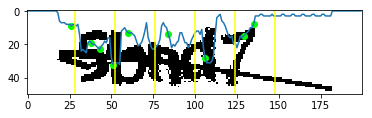

In [306]:
plt.imshow(pixels, cmap="gray")
plt.plot(columns)

for x in edges:
    plt.axvline(x, c="yellow")
plt.scatter(peaks, columns[peaks], c=(0,1,0))
plt.show()